#### To save file size, some of the ouput was cleared. You could redo these inputs to see the result.

In [1]:
import numpy as np
import time

In [12]:
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_svmlight_file
train_data = load_svmlight_file("a9a_train.txt")
test_data = load_svmlight_file("a9a_test.txt")
    
train_X,train_y = train_data[0],train_data[1]
test_X,test_y = test_data[0],test_data[1]
train_X = train_X.toarray()
test_X = test_X.toarray()
train_y = train_y.reshape((len(train_y),1))
test_y = test_y.reshape((len(test_y),1))
    
test_X = np.insert(test_X,121,0,axis=1)
    
train_y2 = (train_y + 1)/2
test_y2 = (test_y + 1)/2

In [30]:
class LogisticRegression(object):
    def __init__(self,shape,method='random'):
        self.W = 0
        self.lambd = 0.0
        if method == 'default':
            #add one dimension of b
            self.W = np.zeros(shape+1)
        elif method == 'random':
            self.W = np.random.rand(shape+1)
        elif method == 'norm':
            self.W = np.random.randn(shape+1)
        self.W = self.W.reshape((len(self.W),1))
        
    def getLoss(self,X,Y,method='l1'):
        #X: samples * features
        #W: features * 1
        #Y: samples * 1
        if method == 'l1':
            temp1 = np.dot(X,self.W) # samples * 1
            temp2 = np.multiply(Y,temp1) # samples * 1
            pureLoss = np.mean(np.log(1 + np.exp(-temp2))) # single value
            totalLoss = pureLoss + self.lambd * np.sum(np.square(self.W))/2
        if method == 'l2':
            temp1 = Y * np.log(self.sigmoid(X))
            temp2 = (1-Y)*(np.log(1-self.sigmoid(X)))
            pureLoss = -np.mean(temp1+temp2)
            totalLoss = pureLoss
        #f.write('pure Loss: '+str(pureLoss)+' total Loss: '+str(totalLoss)+'\n')
        return pureLoss, totalLoss
    
    def randomChoice(self,X,y,size=32):
        num = np.random.choice(len(X)-size-1)
        sample_x = X[num:num+size]
        sample_y = y[num:num+size]
        return sample_x,sample_y
        
    
    def trainWithSGD(self,X_train,y_train,X_val,y_val,batch_size=32,learning_rate=0.01,filename='test1',maxLoop=5):
        #y \in {+1,-1}
        f = open(filename,'w')
        f.write('Start training...\n')
        start = time.time()
        train_losses = []
        val_losses = []
        acc = []
        X_train = np.insert(X_train,0,1,axis=1)
        X_val = np.insert(X_val,0,1,axis=1)
        for i in range(maxLoop):
            X,y = self.randomChoice(X_train,y_train,size=batch_size)
            #temp1 = (1-learning_rate*self.lambd)*self.W #features * 1
            temp1 = self.lambd*self.W
            temp2 = np.multiply(y,np.dot(X,self.W)) #samples * 1
            temp3 = np.multiply(y,X).T #features*samples
            temp4 = np.dot(temp3,1/(1 + np.exp(temp2))) #features * 1
            gradient = temp1 - (1/batch_size)*temp4
            self.W = self.W - learning_rate * gradient
            train_loss = self.getLoss(X_train,y_train)
            val_loss = self.getLoss(X_val,y_val)
            score = self.acc(y_val,self.predict(X_val))
            f.write('\nepoch '+str(i+1)+'   Training loss:   '+str(train_loss)+'  Valing loss:   '+str(val_loss)+' acc: '+str(score)+'\n\n')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            acc.append(score)
        print(time.time()-start)
        f.close()
        return train_losses,val_losses,acc
            
    
    def sigmoid(self,x):
        return 1 / (1.0 + np.exp(-np.dot(x,self.W)))
    
    def trainWithSGD2(self,X_train,y_train,X_val,y_val,batch_size=32,learning_rate=0.01,filename='test1',maxLoop=500):
        #y \in {+1,0}
        f = open(filename,'w')
        f.write('Start training...\n')
        start = time.time()
        train_losses = []
        val_losses = []
        acc = []
        X_train = np.insert(X_train,0,1,axis=1)
        X_val = np.insert(X_val,0,1,axis=1)
        for i in range(maxLoop):
            X,y = self.randomChoice(X_train,y_train,size=batch_size)
            temp1 = self.sigmoid(X)-y
            #按列求均值
            temp2 = np.mean(temp1*X,axis=0) #1*f
            self.W = self.W - learning_rate * (temp2.T)
            train_loss = self.getLoss(X_train,y_train,'l2')
            val_loss = self.getLoss(X_val,y_val,'l2')
            score = self.acc(y_val,self.predict(X_val))
            f.write('\nepoch '+str(i+1)+'   Training loss:   '+str(train_loss)+'  Valing loss:   '+str(val_loss)+' acc: '+str(score)+'\n\n')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            acc.append(score)
        print(time.time()-start)
        f.close()
        return train_losses,val_losses,acc
        
    def trainWithAdam(self,X_train,y_train,X_val,y_val,batch_size=32,learning_rate=0.01,filename='test1',beta1=0.9,beta2=0.999,epsilon=10e-8,maxLoop=500):
        f = open(filename,'w')
        f.write('Start training...\n')
        start = time.time()
        train_losses = []
        val_losses = []
        X_train = np.insert(X_train,0,1,axis=1)
        X_val = np.insert(X_val,0,1,axis=1)
        m = 0
        v = 0
        for t in range(maxLoop):
            X,y = self.randomChoice(X_train,y_train,size=batch_size)
            temp1 = self.lambd*self.W
            temp2 = np.multiply(y,np.dot(X,self.W)) #samples * 1
            temp3 = np.multiply(y,X).T #features*samples
            temp4 = np.dot(temp3,1/(1 + np.exp(temp2))) #features * 1
            gradient = temp1 - (1/batch_size)*temp4
            
            m = beta1*m + (1-beta1)*gradient
            v = beta2*v + (1-beta2)*(np.square(gradient))
            m_bias = m / (1-np.power(beta1,t+1))
            v_bias = v / (1-np.power(beta2,t+1))
            gradient = m_bias / (np.sqrt(v_bias)+epsilon)
            
            self.W = self.W - learning_rate * gradient
            train_loss = self.getLoss(X_train,y_train)
            val_loss = self.getLoss(X_val,y_val)
            f.write('\nepoch '+str(t+1)+'   Training loss:   '+str(train_loss)+'  Valing loss:   '+str(val_loss)+' m'+str(m)+' v'+str(v)+'\n\n')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
        print(time.time()-start)
        f.close()
        return train_losses,val_losses
            
        
    
    def predict(self,X_test,method='l1'):
        #X_test = np.insert(X_test,0,1,axis=1)
        prob = self.sigmoid(X_test)
        if method=='l1':
            pre = np.where(prob>0.5,1,-1)
        if method=='l2':
            pre = np.where(prob>0.5,1,0)
        return pre
    
    def acc(self,y_tru,y_pre):
        count = 0
        for i in range(len(y_tru)):
            if y_tru[i] == y_pre[i]:
                count+=1
        return float(count)/len(y_tru)

In [4]:
#batch=32,rate=0.01,lam=0.0
lrsgd1 = LogisticRegression(train_X.shape[1])
lrsgd1tr,lrsgd1te,lrsgd1acc = lrsgd1.trainWithSGD(train_X,train_y,test_X,test_y,filename='lrsgdlam0batch32rate001',maxLoop=500)

39.89064168930054


In [5]:
#batch=32,rate=0.01,lam=1.0
lrsgd2 = LogisticRegression(train_X.shape[1])
lrsgd2.lambd = 1.0
lrsgd2tr,lrsgd2te,lrsgd2acc = lrsgd2.trainWithSGD(train_X,train_y,test_X,test_y,filename='lrsgd2lam1batch32rate001',maxLoop=500)

40.07382678985596


In [6]:
#batch=32,rate=0.01,lam=10.0
lrsgd3 = LogisticRegression(train_X.shape[1])
lrsgd3.lambd = 10.0
lrsgd3tr,lrsgd3te,lrsgd3acc = lrsgd3.trainWithSGD(train_X,train_y,test_X,test_y,filename='lrsgd3lam10batch32rate001',maxLoop=500)

39.78113770484924


In [7]:
#batch=32,lam=0.0,rate=1.0
lrsgd4 = LogisticRegression(train_X.shape[1])
lrsgd4tr,lrsgd4te,lrsgd4acc = lrsgd4.trainWithSGD(train_X,train_y,test_X,test_y,filename='lrsgd4lam0batch32rate1',learning_rate=1.0,maxLoop=500)

41.66224503517151


In [8]:
#batch=32,lam=0.0,rate=0.0001
lrsgd5 = LogisticRegression(train_X.shape[1])
lrsgd5tr,lrsgd5te,lrsgd5acc = lrsgd5.trainWithSGD(train_X,train_y,test_X,test_y,filename='lrsgd5lam0batch32rate00001',learning_rate=0.0001,maxLoop=500)

39.71640181541443


In [9]:
#lam=0.0,rate=0.01,batch=16
lrsgd6 = LogisticRegression(train_X.shape[1])
lrsgd6tr,lrsgd6te,lrsgd6acc = lrsgd6.trainWithSGD(train_X,train_y,test_X,test_y,filename='lrsgd6lam0batch16rate001',batch_size=16,maxLoop=500)

40.671228647232056


In [10]:
#lam=0.0,rate=0.01,batch=64
lrsgd7 = LogisticRegression(train_X.shape[1])
lrsgd7tr,lrsgd7te,lrsgd7acc = lrsgd7.trainWithSGD(train_X,train_y,test_X,test_y,filename='lrsgd7lam0batch64rate001',batch_size=64,maxLoop=500)

41.043086528778076


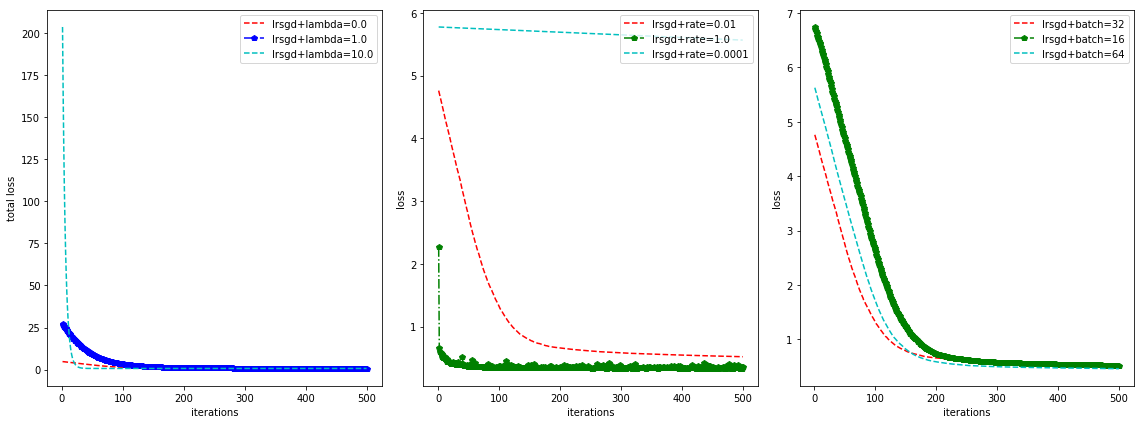

In [26]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(1,3,1)
ax1.plot(range(1,len(lrsgd1te)+1), [i[1] for i in lrsgd1te], 'r--')
ax1.plot(range(1,len(lrsgd2te)+1), [i[1] for i in lrsgd2te], 'bp-.')
ax1.plot(range(1,len(lrsgd3te)+1), [i[1] for i in lrsgd3te], 'c--')
label1 = ['lrsgd+lambda=0.0', 'lrsgd+lambda=1.0','lrsgd+lambda=10.0'] 
ax1.legend(label1, loc='upper right')
ax1.set_xlabel('iterations')
ax1.set_ylabel('total loss')

ax2 = plt.subplot(1,3,2)
ax2.plot(range(1,len(lrsgd1te)+1), [i[1] for i in lrsgd1te], 'r--')
ax2.plot(range(1,len(lrsgd4te)+1), [i[1] for i in lrsgd4te], 'gp-.')
ax2.plot(range(1,len(lrsgd5te)+1), [i[1] for i in lrsgd5te], 'c--')
label2 = ['lrsgd+rate=0.01', 'lrsgd+rate=1.0','lrsgd+rate=0.0001'] 
ax2.legend(label2, loc='upper right')
ax2.set_xlabel('iterations')
ax2.set_ylabel('loss')

ax3 = plt.subplot(1,3,3)
ax3.plot(range(1,len(lrsgd1te)+1), [i[1] for i in lrsgd1te], 'r--')
ax3.plot(range(1,len(lrsgd6te)+1), [i[1] for i in lrsgd6te], 'gp-.')
ax3.plot(range(1,len(lrsgd7te)+1), [i[1] for i in lrsgd7te], 'c--')
label3 = ['lrsgd+batch=32', 'lrsgd+batch=16','lrsgd+batch=64'] 
ax3.legend(label3, loc='upper right')
ax3.set_xlabel('iterations')
ax3.set_ylabel('loss')

plt.tight_layout()
#plt.subplots_adjust(wspace =2, hspace =2)
plt.savefig('gg3.pdf')
plt.show()

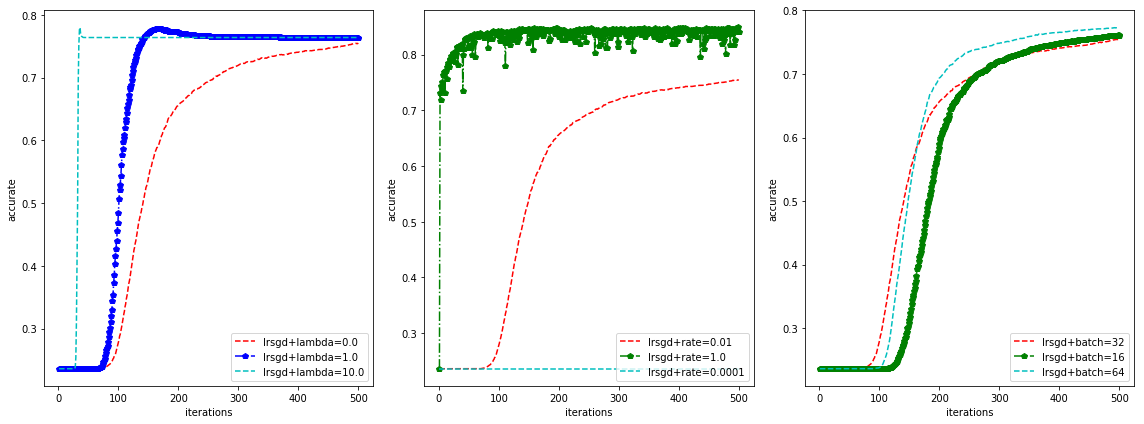

In [41]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(1,3,1)
ax1.plot(range(1,len(lrsgd1acc)+1), lrsgd1acc, 'r--')
ax1.plot(range(1,len(lrsgd2acc)+1), lrsgd2acc, 'bp-.')
ax1.plot(range(1,len(lrsgd3acc)+1), lrsgd3acc, 'c--')
label1 = ['lrsgd+lambda=0.0', 'lrsgd+lambda=1.0','lrsgd+lambda=10.0'] 
ax1.legend(label1, loc='lower right')
ax1.set_xlabel('iterations')
ax1.set_ylabel('accurate')

ax2 = plt.subplot(1,3,2)
ax2.plot(range(1,len(lrsgd1acc)+1), lrsgd1acc, 'r--')
ax2.plot(range(1,len(lrsgd4acc)+1), lrsgd4acc, 'gp-.')
ax2.plot(range(1,len(lrsgd5acc)+1), lrsgd5acc, 'c--')
label2 = ['lrsgd+rate=0.01', 'lrsgd+rate=1.0','lrsgd+rate=0.0001'] 
ax2.legend(label2, loc='lower right')
ax2.set_xlabel('iterations')
ax2.set_ylabel('accurate')

ax3 = plt.subplot(1,3,3)
ax3.plot(range(1,len(lrsgd1acc)+1), lrsgd1acc, 'r--')
ax3.plot(range(1,len(lrsgd6acc)+1), lrsgd6acc, 'gp-.')
ax3.plot(range(1,len(lrsgd7acc)+1), lrsgd7acc, 'c--')
label3 = ['lrsgd+batch=32', 'lrsgd+batch=16','lrsgd+batch=64'] 
ax3.legend(label3, loc='lower right')
ax3.set_xlabel('iterations')
ax3.set_ylabel('accurate')

plt.tight_layout()
#plt.subplots_adjust(wspace =2, hspace =2)
plt.savefig('gg4.pdf')
plt.show()

In [42]:
#batch=32,rate=0.01,lam=0.0
lradam1 = LogisticRegression(train_X.shape[1])
lradam1tr,lradam1te,lradam1acc = lradam1.trainWithAdam(train_X,train_y,test_X,test_y,filename='lradamlam0batch32rate001',maxLoop=3000)

254.23438048362732


In [43]:
#batch=32,rate=0.01,lam=1.0
lradam2 = LogisticRegression(train_X.shape[1])
lradam2.lambd = 1.0
lradam2tr,lradam2te,lradam2acc = lradam2.trainWithAdam(train_X,train_y,test_X,test_y,filename='lradam2lam1batch32rate001',maxLoop=3000)

253.89601802825928


In [44]:
#batch=32,rate=0.01,lam=10.0
lradam3 = LogisticRegression(train_X.shape[1])
lradam3.lambd = 10.0
lradam3tr,lradam3te,lradam3acc = lradam3.trainWithAdam(train_X,train_y,test_X,test_y,filename='lradam3lam10batch32rate001',maxLoop=3000)

253.96609497070312


In [45]:
#batch=32,lam=0.0,rate=1.0
lradam4 = LogisticRegression(train_X.shape[1])
lradam4.lambd = 0.0
lradam4tr,lradam4te,lradam4acc = lradam4.trainWithAdam(train_X,train_y,test_X,test_y,filename='lradam4lam0batch32rate1',learning_rate=1.0,maxLoop=3000)

251.66532564163208


In [46]:
#batch=32,lam=0.0,rate=0.0001
lradam5 = LogisticRegression(train_X.shape[1])
lradam5.lambd = 0.0
lradam5tr,lradam5te,lradam5acc = lradam5.trainWithAdam(train_X,train_y,test_X,test_y,filename='lradam5lam0batch32rate00001',learning_rate=0.0001,maxLoop=3000)

246.92852473258972


In [47]:
#rate=0.01,lam=0.0,batch=16
lradam6 = LogisticRegression(train_X.shape[1])
lradam6.lambd = 0.0
lradam6tr,lradam6te,lradam6acc = lradam6.trainWithAdam(train_X,train_y,test_X,test_y,filename='lradam6lam0batch16rate001',batch_size=16,maxLoop=3000)

250.24489998817444


In [48]:
#rate=0.01,lam=0.0,batch=64
lradam7 = LogisticRegression(train_X.shape[1])
lradam7.lambd = 0.0
lradam7tr,lradam7te,lradam7acc = lradam7.trainWithAdam(train_X,train_y,test_X,test_y,filename='lradam7lam0batch64rate001',batch_size=64,maxLoop=3000)

250.82413411140442


In [ ]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(1,3,1)
ax1.plot(range(1,len(lradam1te)+1), [i[1] for i in lradam1te], 'r--')
ax1.plot(range(1,len(lradam2te)+1), [i[1] for i in lradam2te], 'bp-.')
ax1.plot(range(1,len(lradam3te)+1), [i[1] for i in lradam3te], 'c--')
label1 = ['lradam+lambda=0.0', 'lradam+lambda=1.0','lradam+lambda=10.0'] 
ax1.legend(label1, loc='upper right')
ax1.set_xlabel('iterations')
ax1.set_ylabel('total loss')

ax2 = plt.subplot(1,3,2)
ax2.plot(range(1,len(lradam1te)+1), [i[1] for i in lradam1te], 'r--')
ax2.plot(range(1,len(lradam4te)+1), [i[1] for i in lradam4te], 'gp-.')
ax2.plot(range(1,len(lradam5te)+1), [i[1] for i in lradam5te], 'c--')
label2 = ['lradam+rate=0.01', 'lradam+rate=1.0','lradam+rate=0.0001'] 
ax2.legend(label2, loc='upper right')
ax2.set_xlabel('iterations')
ax2.set_ylabel('loss')

ax3 = plt.subplot(1,3,3)
ax3.plot(range(1,len(lradam1te)+1), [i[1] for i in lradam1te], 'r--')
ax3.plot(range(1,len(lradam6te)+1), [i[1] for i in lradam6te], 'gp-.')
ax3.plot(range(1,len(lradam7te)+1), [i[1] for i in lradam7te], 'c--')
label3 = ['lradam+batch=32', 'lradam+batch=16','lradam+batch=64'] 
ax3.legend(label3, loc='upper right')
ax3.set_xlabel('iterations')
ax3.set_ylabel('loss')

plt.tight_layout()
#plt.subplots_adjust(wspace =2, hspace =2)
plt.savefig('adam3000l.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(1,3,1)
ax1.plot(range(1,len(lradam1acc)+1), lradam1acc, 'r--')
ax1.plot(range(1,len(lradam2acc)+1), lradam2acc, 'bp-.')
ax1.plot(range(1,len(lradam3acc)+1), lradam3acc, 'c--')
label1 = ['lradam+lambda=0.0', 'lradam+lambda=1.0','lradam+lambda=10.0'] 
ax1.legend(label1, loc='lower right')
ax1.set_xlabel('iterations')
ax1.set_ylabel('accurate')

ax2 = plt.subplot(1,3,2)
ax2.plot(range(1,len(lradam1acc)+1), lradam1acc, 'r--')
ax2.plot(range(1,len(lradam4acc)+1), lradam4acc, 'gp-.')
ax2.plot(range(1,len(lradam5acc)+1), lradam5acc, 'c--')
label2 = ['lradam+rate=0.01', 'lradamd+rate=1.0','lradam+rate=0.0001'] 
ax2.legend(label2, loc='lower right')
ax2.set_xlabel('iterations')
ax2.set_ylabel('accurate')

ax3 = plt.subplot(1,3,3)
ax3.plot(range(1,len(lradam1acc)+1), lradam1acc, 'r--')
ax3.plot(range(1,len(lradam6acc)+1), lradam6acc, 'gp-.')
ax3.plot(range(1,len(lradam7acc)+1), lradam7acc, 'c--')
label3 = ['lradam+batch=32', 'lradam+batch=16','lradam+batch=64'] 
ax3.legend(label3, loc='lower right')
ax3.set_xlabel('iterations')
ax3.set_ylabel('accurate')

plt.tight_layout()
#plt.subplots_adjust(wspace =2, hspace =2)
plt.savefig('adam3000a.pdf')
plt.show()

In [51]:
class SVMClassification(object):
    def __init__(self,shape,c=1.0,method='random'):
        self.W = 0
        self.b = 0.0
        if method == 'default':
            #add one dimension of b
            self.W = np.zeros(shape+1)
            self.b = 0.0
        elif method == 'random':
            self.W = np.random.rand(shape+1)
            self.b = np.random.random()
        elif method == 'norm':
            self.W = np.random.randn(shape+1)
            self.b = np.random.random()
        self.C = c
        self.W = self.W.reshape((len(self.W),1))
        
    def getLoss(self,X,Y):
        #x: samples*features
        #y: samples*1
        #W:features*1
        temp1 = np.sum(np.square(self.W))/2.0
        temp2 = 1-np.multiply(Y,(np.dot(X,self.W)+self.b))
        temp3 = np.maximum(temp2,0)
        loss = temp1 + self.C * np.mean(temp3)
        return loss
    
    def randomChoice(self,X,y,size=32):
        num = np.random.choice(len(X)-size-1)
        sample_x = X[num:num+size]
        sample_y = y[num:num+size]
        return sample_x,sample_y
    
    def trainWithSGD(self,X_train,y_train,X_val,y_val,batch_size=32,learning_rate=0.01,filename='test1',maxLoop=500):
        #y \in {+1,0}
        f = open(filename,'w')
        f.write('Start training...\n')
        start = time.time()
        train_losses = []
        val_losses = []
        acc = []
        X_train = np.insert(X_train,0,1,axis=1)
        X_val = np.insert(X_val,0,1,axis=1)
        for i in range(maxLoop):
            X,y = self.randomChoice(X_train,y_train,size=batch_size)
            #update w
            temp = 1-np.multiply(y,(np.dot(X,self.W)+self.b)) #samples*1
            temp2 = np.mean(np.where(temp>=0,-np.multiply(y,X),0),axis=0)
            temp2 = temp2.reshape((len(temp2),1))
            w_gradient = self.W + self.C * temp2
            self.W = self.W - learning_rate * w_gradient
            #update b
            temp3 = np.where(temp>=0,-y,0) #samples*1
            b_gradient = self.C * np.mean(temp3)
            self.b = self.b - learning_rate * b_gradient
            train_loss = self.getLoss(X_train,y_train)
            val_loss = self.getLoss(X_val,y_val)
            score = self.acc(y_val,self.predict(X_val))
            f.write('\nepoch '+str(i+1)+'   Training loss:   '+str(train_loss)+'  Valing loss:   '+str(val_loss)+' Score: '+str(score)+'\n\n')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            acc.append(score)
        print(time.time()-start)
        f.close()
        return train_losses,val_losses,acc
        
    
    def trainWithAdam(self,X_train,y_train,X_val,y_val,batch_size=32,learning_rate=0.01,filename='test1',beta1=0.9,beta2=0.999,epsilon=10e-8,maxLoop=500):
        f = open(filename,'w')
        f.write('Start training...\n')
        start = time.time()
        train_losses = []
        val_losses = []
        acc = []
        X_train = np.insert(X_train,0,1,axis=1)
        X_val = np.insert(X_val,0,1,axis=1)
        mw = 0
        vw = 0
        mb = 0
        vb = 0
        for t in range(maxLoop):
            X,y = self.randomChoice(X_train,y_train,size=batch_size)
            #calculate gradient w
            temp = 1-np.multiply(y,(np.dot(X,self.W)+self.b)) #samples*1
            temp2 = np.mean(np.where(temp>=0,-np.multiply(y,X),0),axis=0)
            temp2 = temp2.reshape((len(temp2),1))
            w_gradient = self.W + self.C * temp2
            mw = beta1*mw + (1-beta1)*w_gradient
            vw = beta2*vw + (1-beta2)*(np.square(w_gradient))
            mw_bias = mw / (1-np.power(beta1,t+1))
            vw_bias = vw / (1-np.power(beta2,t+1))
            w_gradient = mw_bias / (np.sqrt(vw_bias)+epsilon)
            
            #calculate gradient b
            temp3 = np.where(temp>=0,-y,0) #samples*1
            b_gradient = self.C * np.mean(temp3)
            mb = beta1*mb + (1-beta1)*b_gradient
            vb = beta2*vb + (1-beta2)*(np.square(b_gradient))
            mb_bias = mb / (1-np.power(beta1,t+1))
            vb_bias = vb / (1-np.power(beta2,t+1))
            b_gradient = mb_bias / (np.sqrt(vb_bias)+epsilon)
            
            #update parameter W,b
            self.W = self.W -  learning_rate * w_gradient
            self.b = self.b - learning_rate * b_gradient
            
            #calculate loss
            train_loss = self.getLoss(X_train,y_train)
            val_loss = self.getLoss(X_val,y_val)
            score = self.acc(y_val,self.predict(X_val))
            f.write('\nepoch '+str(t+1)+'   Training loss:   '+str(train_loss)+'  Valing loss:   '+str(val_loss)+' Score: '+str(score)+'\n\n')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            acc.append(score)
        print(time.time()-start)
        f.close()
        return train_losses,val_losses,acc
        
    
    def predict(self,X_test):
        #X_test = np.insert(X_test,0,1,axis=1)
        temp = np.dot(X_test,self.W) + self.b
        pre = np.where(temp>=0,+1,-1)
        return pre
    
    def acc(self,y_tru,y_pre):
        count = 0
        for i in range(len(y_tru)):
            if y_tru[i] == y_pre[i]:
                count+=1
        return float(count)/len(y_tru)

In [52]:
#batch_size=32,rate=0.01,C=1.0
svmsgd1 = SVMClassification(train_X.shape[1],c=1.0)
svmsgd1tr,svmsgd1te,svmsgd1acc = svmsgd1.trainWithSGD(train_X,train_y,test_X,test_y,filename='svmsgd1c1size32rate001')

37.584542751312256


In [53]:
#batch_size=32,rate=0.01,C=10.0
svmsgd2 = SVMClassification(train_X.shape[1],c=10.0)
svmsgd2tr,svmsgd2te,svmsgd2acc = svmsgd2.trainWithSGD(train_X,train_y,test_X,test_y,filename='svmsgd2c10size32rate001')

38.48994588851929


In [54]:
#batch_size=32,rate=0.01,C=100.0
svmsgd3 = SVMClassification(train_X.shape[1],c=100.0)
svmsgd3tr,svmsgd3te,svmsgd3acc = svmsgd3.trainWithSGD(train_X,train_y,test_X,test_y,filename='svmsgd3c100size32rate001')

39.12004351615906


In [55]:
#batch_size=32,rate=1.0,c=1.0
svmsgd4 = SVMClassification(train_X.shape[1],c=1.0)
svmsgd4tr,svmsgd4te,svmsgd4acc = svmsgd1.trainWithSGD(train_X,train_y,test_X,test_y,filename='svmsgd4c1size32rate1',learning_rate=1.0)

40.31569838523865


In [56]:
#batch_size=32,rate=0.0001,c=1.0
svmsgd5 = SVMClassification(train_X.shape[1],c=1.0)
svmsgd5tr,svmsgd5te,svmsgd5acc = svmsgd5.trainWithSGD(train_X,train_y,test_X,test_y,filename='svmsgd5c1size32rate00001',learning_rate=0.0001)

38.18028521537781


In [57]:
#rate=0.01,c=1.0,batch=16
svmsgd6 = SVMClassification(train_X.shape[1],c=1.0)
svmsgd6tr,svmsgd6te,svmsgd6acc = svmsgd6.trainWithSGD(train_X,train_y,test_X,test_y,filename='svmsgd6c1size16rate001',batch_size=16)

38.18647384643555


In [58]:
#rate=0.01,c=1.0,batch=64
svmsgd7 = SVMClassification(train_X.shape[1],c=1.0)
svmsgd7tr,svmsgd7te,svmsgd7acc = svmsgd7.trainWithSGD(train_X,train_y,test_X,test_y,filename='svmsgd7c1size64rate001',batch_size=64)

39.954095125198364


In [ ]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(1,3,1)
ax1.plot(range(1,len(svmsgd1te)+1), svmsgd1te, 'r--')
ax1.plot(range(1,len(svmsgd2te)+1), svmsgd2te, 'bp-.')
ax1.plot(range(1,len(svmsgd3te)+1), svmsgd3te, 'c--')
label1 = ['svmsgd+c=1.0', 'svmsgd+c=10.0','svmsgd+c=100.0'] 
ax1.legend(label1, loc='upper right')
ax1.set_xlabel('iterations')
ax1.set_ylabel('total loss')

ax2 = plt.subplot(1,3,2)
ax2.plot(range(1,len(svmsgd1te)+1), svmsgd1te, 'r--')
ax2.plot(range(1,len(svmsgd4te)+1), svmsgd4te, 'gp-.')
ax2.plot(range(1,len(svmsgd5te)+1), svmsgd5te, 'c--')
label2 = ['svmsgd+rate=0.01', 'svmsgd+rate=1.0','svmsgd+rate=0.0001'] 
ax2.legend(label2, loc='upper right')
ax2.set_xlabel('iterations')
ax2.set_ylabel('loss')

ax3 = plt.subplot(1,3,3)
ax3.plot(range(1,len(svmsgd1te)+1), svmsgd1te, 'r--')
ax3.plot(range(1,len(svmsgd6te)+1), svmsgd6te, 'gp-.')
ax3.plot(range(1,len(svmsgd7te)+1), svmsgd7te, 'c--')
label3 = ['svmsgd+batch=32', 'svmsgd+batch=16','svmsgd+batch=64'] 
ax3.legend(label3, loc='upper right')
ax3.set_xlabel('iterations')
ax3.set_ylabel('loss')

plt.tight_layout()
#plt.subplots_adjust(wspace =2, hspace =2)
plt.savefig('svmsgd500l.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(1,3,1)
ax1.plot(range(1,len(svmsgd1acc)+1), svmsgd1acc, 'r--')
ax1.plot(range(1,len(svmsgd2acc)+1), svmsgd2acc, 'bp-.')
ax1.plot(range(1,len(svmsgd3acc)+1), svmsgd3acc, 'c--')
label1 = ['svmsgd+c=1.0', 'svmsgd+c=10.0','svmsgd+c=100.0'] 
ax1.legend(label1, loc='lower right')
ax1.set_xlabel('iterations')
ax1.set_ylabel('accurate')

ax2 = plt.subplot(1,3,2)
ax2.plot(range(1,len(svmsgd1acc)+1), svmsgd1acc, 'r--')
ax2.plot(range(1,len(svmsgd4acc)+1), svmsgd4acc, 'gp-.')
ax2.plot(range(1,len(svmsgd5acc)+1), svmsgd5acc, 'c--')
label2 = ['svmsgd+rate=0.01', 'svmsgd+rate=1.0','svmsgd+rate=0.0001'] 
ax2.legend(label2, loc='lower right')
ax2.set_xlabel('iterations')
ax2.set_ylabel('accurate')

ax3 = plt.subplot(1,3,3)
ax3.plot(range(1,len(svmsgd1acc)+1), svmsgd1acc, 'r--')
ax3.plot(range(1,len(svmsgd6acc)+1), svmsgd6acc, 'gp-.')
ax3.plot(range(1,len(svmsgd7acc)+1), svmsgd7acc, 'c--')
label3 = ['svmsgd+batch=32', 'svmsgd+batch=16','svmsgd+batch=64'] 
ax3.legend(label3, loc='lower right')
ax3.set_xlabel('iterations')
ax3.set_ylabel('accurate')

plt.tight_layout()
#plt.subplots_adjust(wspace =2, hspace =2)
plt.savefig('svmsgd500a.pdf')
plt.show()

In [63]:
#batch_size=32,rate=0.01,C=1.0
svmadam1 = SVMClassification(train_X.shape[1],c=1.0)
svmadam1tr,svmadam1te,svmadam1acc = svmadam1.trainWithAdam(train_X,train_y,test_X,test_y,filename='svmadam1c1size32rate001')

39.97126865386963


In [64]:
#batch_size=32,rate=0.01,C=10.0
svmadam2 = SVMClassification(train_X.shape[1],c=10.0)
svmadam2tr,svmadam2te,svmadam2acc = svmadam2.trainWithAdam(train_X,train_y,test_X,test_y,filename='svmadam2c10size32rate001')

38.88247323036194


In [65]:
#batch_size=32,rate=0.01,C=100.0
svmadam3 = SVMClassification(train_X.shape[1],c=100.0)
svmadam3tr,svmadam3te,svmadam3acc = svmadam3.trainWithAdam(train_X,train_y,test_X,test_y,filename='svmadam3c100size32rate001')

39.12607455253601


In [66]:
#batch_size=32,c=1.0,rate=1,0
svmadam4 = SVMClassification(train_X.shape[1],c=1.0)
svmadam4tr,svmadam4te,svmadam4acc = svmadam4.trainWithAdam(train_X,train_y,test_X,test_y,filename='svmadam4c1size32rate1',learning_rate=1.0)

38.76017141342163


In [67]:
#batch_size=32,c=1.0,rate=0.0001
svmadam5 = SVMClassification(train_X.shape[1],c=1.0)
svmadam5tr,svmadam5te,svmadam5acc = svmadam5.trainWithAdam(train_X,train_y,test_X,test_y,filename='svmadam5c1size32rate00001',learning_rate=0.0001)

38.45426154136658


In [68]:
#rate=0,01,c=1.0,size=16
svmadam6 = SVMClassification(train_X.shape[1],c=1.0)
svmadam6tr,svmadam6te,svmadam6acc = svmadam6.trainWithAdam(train_X,train_y,test_X,test_y,filename='svmadam6c1size16rate001',batch_size=16)

39.65719985961914


In [69]:
#rate=0,01,c=1.0,size=64
svmadam7 = SVMClassification(train_X.shape[1],c=1.0)
svmadam7tr,svmadam7te,svmadam7acc = svmadam7.trainWithAdam(train_X,train_y,test_X,test_y,filename='svmadam7c1size64rate001',batch_size=64)

38.18319892883301


In [ ]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(1,3,1)
ax1.plot(range(1,len(svmadam1te)+1), svmadam1te, 'r--')
ax1.plot(range(1,len(svmadam2te)+1), svmadam2te, 'bp-.')
ax1.plot(range(1,len(svmadam3te)+1), svmadam3te, 'c--')
label1 = ['svmadam+c=1.0', 'svmadam+c=10.0','svmadam+c=100.0'] 
ax1.legend(label1, loc='upper right')
ax1.set_xlabel('iterations')
ax1.set_ylabel('total loss')

ax2 = plt.subplot(1,3,2)
ax2.plot(range(1,len(svmadam1te)+1), svmadam1te, 'r--')
ax2.plot(range(1,len(svmadam4te)+1), svmadam4te, 'gp-.')
ax2.plot(range(1,len(svmadam5te)+1), svmadam5te, 'c--')
label2 = ['svmadam+rate=0.01', 'svmadam+rate=1.0','svmadam+rate=0.0001'] 
ax2.legend(label2, loc='upper right')
ax2.set_xlabel('iterations')
ax2.set_ylabel('loss')

ax3 = plt.subplot(1,3,3)
ax3.plot(range(1,len(svmadam1te)+1), svmadam1te, 'r--')
ax3.plot(range(1,len(svmadam6te)+1), svmadam6te, 'gp-.')
ax3.plot(range(1,len(svmadam7te)+1), svmadam7te, 'c--')
label3 = ['svmadam+batch=32', 'svmadam+batch=16','svmadam+batch=64'] 
ax3.legend(label3, loc='upper right')
ax3.set_xlabel('iterations')
ax3.set_ylabel('loss')

plt.tight_layout()
#plt.subplots_adjust(wspace =2, hspace =2)
plt.savefig('svmadam500l.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(1,3,1)
ax1.plot(range(1,len(svmadam1acc)+1), svmadam1acc, 'r--')
ax1.plot(range(1,len(svmadam2acc)+1), svmadam2acc, 'bp-.')
ax1.plot(range(1,len(svmadam3acc)+1), svmadam3acc, 'c--')
label1 = ['svmadam+c=1.0', 'svmadam+c=10.0','svmadam+c=100.0'] 
ax1.legend(label1, loc='lower right')
ax1.set_xlabel('iterations')
ax1.set_ylabel('accurate')

ax2 = plt.subplot(1,3,2)
ax2.plot(range(1,len(svmadam1acc)+1), svmadam1acc, 'r--')
ax2.plot(range(1,len(svmadam4acc)+1), svmadam4acc, 'gp-.')
ax2.plot(range(1,len(svmadam5acc)+1), svmadam5acc, 'c--')
label2 = ['svmadam+rate=0.01', 'svmadam+rate=1.0','svmadam+rate=0.0001'] 
ax2.legend(label2, loc='lower right')
ax2.set_xlabel('iterations')
ax2.set_ylabel('accurate')

ax3 = plt.subplot(1,3,3)
ax3.plot(range(1,len(svmadam1acc)+1), svmadam1acc, 'r--')
ax3.plot(range(1,len(svmadam6acc)+1), svmadam6acc, 'gp-.')
ax3.plot(range(1,len(svmadam7acc)+1), svmadam7acc, 'c--')
label3 = ['svmadam+batch=32', 'svmadam+batch=16','svmadam+batch=64'] 
ax3.legend(label3, loc='lower right')
ax3.set_xlabel('iterations')
ax3.set_ylabel('accurate')

plt.tight_layout()
#plt.subplots_adjust(wspace =2, hspace =2)
plt.savefig('svmadam500a.pdf')
plt.show()